This notebook shows the code contained in the *Python Objects* plotted in the *Power BI* dashboard

In [1]:
# The following code to create a dataframe and remove duplicated rows is always executed and acts as a preamble for your script: 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

from mplsoccer import Radar, FontManager, grid


def init_radar(dataset, low, high, lower_is_better):
    # parameter names of the statistics we want to show
    params = list(dataset)[1:]

    # The lower and upper boundaries for the statistics
    # low, high
    
    # Columns where having a lower number is better this flips the statistic
    #lower_is_better

    radar = Radar(params, low, high, lower_is_better=lower_is_better,
                num_rings=5, 
                ring_width=1, center_circle_radius=1)

    fig, ax = radar.setup_axis()  # format axis as a radar
    rings_inner = radar.draw_circles(ax=ax, facecolor=(0.7,0,0), edgecolor=(1,0,0), alpha=0.15)  # draw circles
    return ax, radar


def draw_row(row, radar, ax, col):
    radar_output = radar.draw_radar_solid(row, ax=ax,
                                    kwargs={'facecolor': col, 'alpha' : 0.2, 'lw': 5},)  # draw the radar
    radar_poly, v = radar_output
    return v

In [2]:
def draw_dataset_radar(dataset, low, high, lower_better, out_name):

    # color list for different players
    col = list(mcolors.TABLEAU_COLORS)

    ax, radar = init_radar(dataset, low, high, lower_better)
    
    pl_names = list(dataset['Player'])

    for i in range(0,len(pl_names)):
        v = draw_row(list(dataset.iloc[i,1:]), radar, ax, col[i])
        ax.scatter(v[:, 0], v[:, 1], color=col[i], marker='o', s=30, label=pl_names[i])

    # Draw radar params
    range_labels = radar.draw_range_labels(ax=ax, fontsize=14)  # draw the range labels
    param_labels = radar.draw_param_labels(ax=ax, fontsize=20)  # draw the param labels 
    lines = radar.spoke(ax=ax, color=(0,0,0), linestyle='--', alpha=0.25) # axis lines
    
    ax.legend(fontsize=12)
    plt.title(f'Stats normalized by 90\' played', fontsize=16)
    plt.savefig(f'plots/{out_name}.png', bbox_inches='tight', transparent=True)

# Goalkeeping

In [3]:
def draw_gk_radar(dataset, out_name, players=[]):
    # Selecting important columns and normalizing to 90 min played
    dataset = dataset[['Player', 'Min', 'GA', 'PSxG', 'Saves', 'SoTA', 'CleanSheets']]
    dataset = dataset.groupby(['Player']).apply(lambda x: np.sum(x)).drop(['Player'], axis=1).reset_index()
    saving = 100*(dataset['Saves']/dataset['SoTA'])
    dataset.insert(6, 'Saving%', saving)

    no_normalize = ['Min', 'Player', 'CleanSheets', 'Saving%']
    dataset = dataset.apply(lambda x: x if x.name in no_normalize else 90*x.div(dataset['Min'], axis=0))
    
    low = [min(dataset[x]) for x in list(dataset.iloc[:,1:])]
    high = [max(dataset[x]) for x in list(dataset.iloc[:,1:])]

    # Select players or Top5 minutes played
    if len(players):
        dataset = dataset[dataset['Player'].isin(players)]
    else:
        dataset.sort_values(['Min'], ascending=False, inplace=True)
        dataset = dataset.iloc[:5,:]

    lower_is_better = ['GA', 'PSxG']
    draw_dataset_radar(dataset, low, high, lower_is_better, out_name)

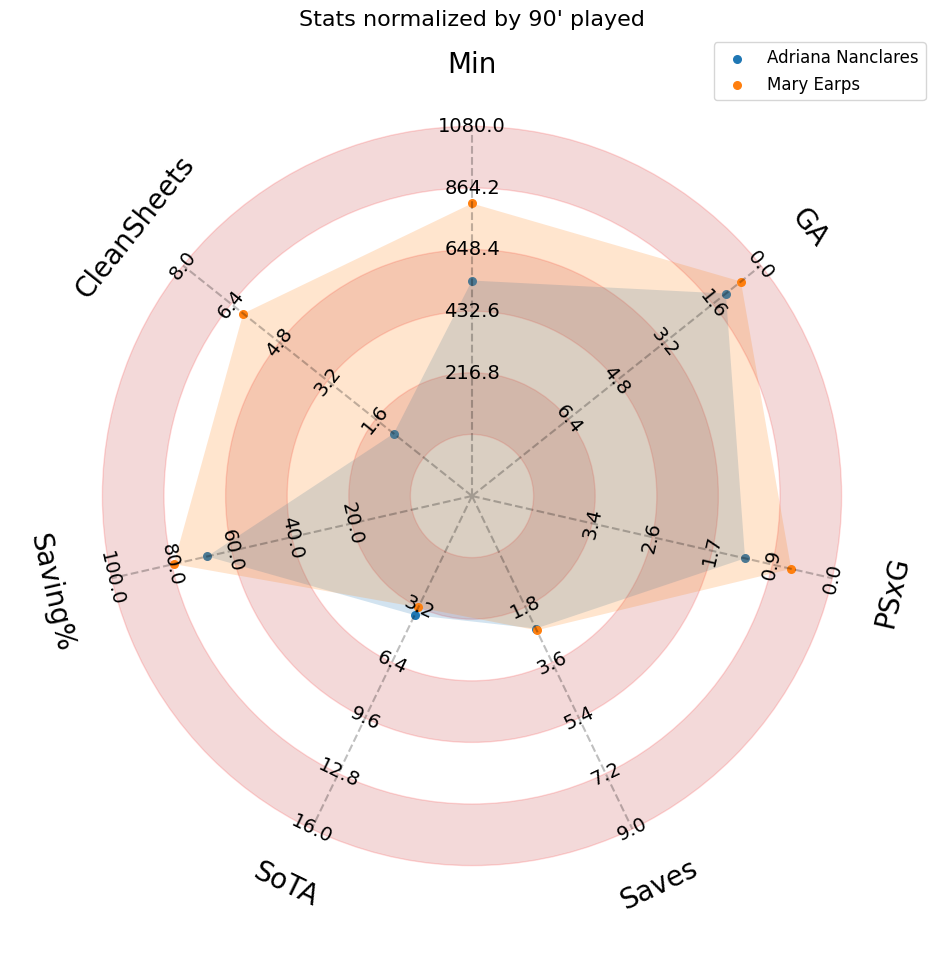

In [4]:
dataset = pd.read_csv('datasets/gk_players.csv')
draw_gk_radar(dataset, 'gk_radar', ['Adriana Nanclares', 'Mary Earps'])

# Players Stats 

In [5]:
stats = {
    'Attacking' : ['Gls', 'xG', 'Sh', 'SoT', 'FK'],
    'Defending' : ['CrdY', 'CrdR', 'Tkl', 'TklW', 'Blocks', 'Int', 'Recov'],
    'Passing' : ['Ast', 'xAG', 'Passes_Att', 'Passes_Cmp'],
    'Possession' : ['Touches']
}

def draw_player_radar(dataset, stats_type, out_name, players=[]):
    cols = ['Player', 'Min']
    cols.extend(stats[stats_type])
    
    # Selecting important columns and normalizing to 90 min played
    dataset = dataset[cols]
    dataset = dataset.groupby(['Player']).apply(lambda x: np.sum(x)).drop(['Player'], axis=1).reset_index()
    
    no_normalize = ['Min', 'Player', 'CrdR', 'CrdY']
    dataset = dataset.apply(lambda x: x if x.name in no_normalize else 90*x.div(dataset['Min'], axis=0))
    
    low = [min(dataset[x]) for x in list(dataset.iloc[:,1:])]
    high = [max(dataset[x]) for x in list(dataset.iloc[:,1:])]

    # Select players or Top5 minutes played
    if len(players):
        dataset = dataset[dataset['Player'].isin(players)]
    else:
        dataset.sort_values(['Min'], ascending=False, inplace=True)
        dataset = dataset.iloc[:5,:]

    lower_is_better = []
    draw_dataset_radar(dataset, low, high, lower_is_better, out_name)

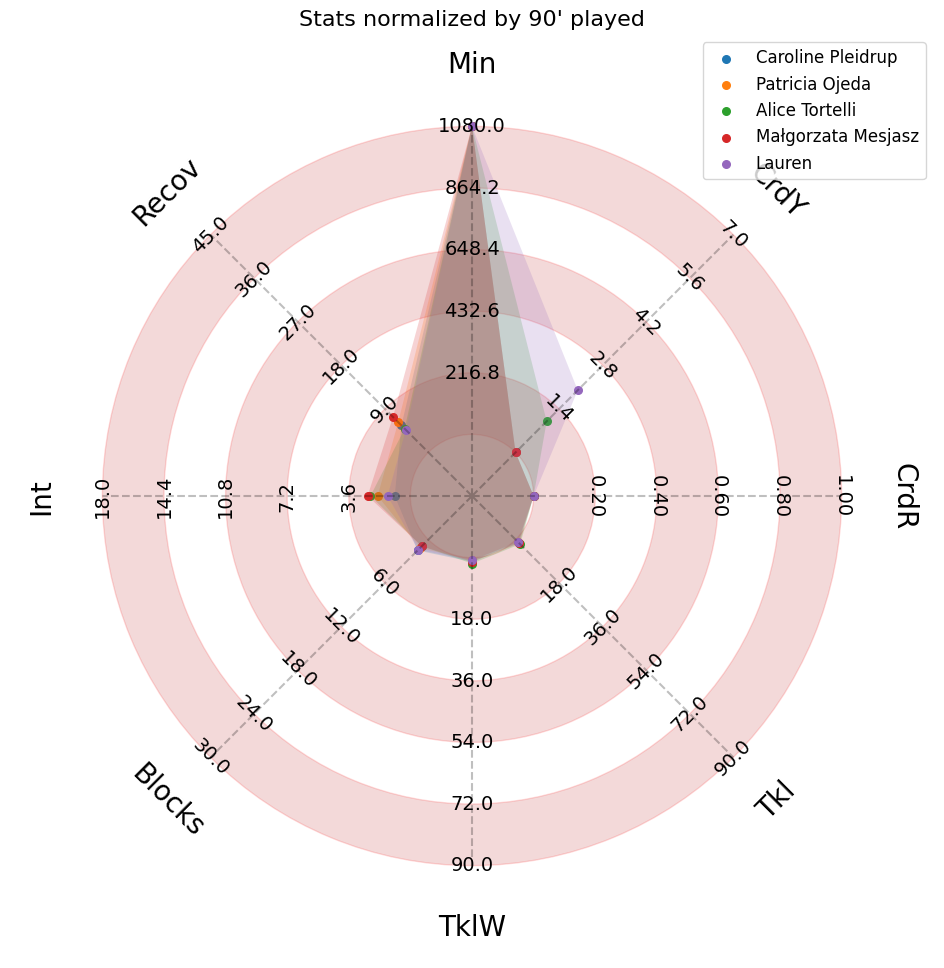

In [6]:
dataset = pd.read_csv('datasets/all_players.csv')

dataset = dataset[dataset['Pos'].str.startswith(('DF', 'MF'))]
draw_player_radar(dataset, 'Defending', 'players_radar')